Based on https://huggingface.co/nlpconnect/vit-gpt2-image-captioning

In [1]:
#!pip install transformers[torch]

In [2]:
#!pip install datasets

In [3]:
#!pip install nltk

In [4]:
#!pip install Pillow

In [1]:
import os
import datasets
from PIL import Image, ImageDraw
import numpy as np
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor,AutoTokenizer
os.environ["WANDB_DISABLED"] = "true"

In [2]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [3]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.4.crossattention.bias', 'h.5.ln_cross_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.11.crossattention.masked_bias', 'h.4.crossattention.c_proj.bias', 'h.11.ln_cross_attn.weight', 'h.2.crossattention.masked_bias', 'h.0.crossattention.c_proj.bias', 'h.0.ln_cross_attn.weight', 'h.3.crossattention.c_proj.bias', 'h.10.crossattention.masked_bias', 'h.10.crossattention.c_attn.weight', 'h.9.crossattention.bias', 'h.5.crossattention.masked_bias', 'h.8.ln_cross_attn.weight', 'h.6.crossattention.bias', 'h.10.ln_cross_attn.weight', 'h.5.crossattention.q_attn.weight', 'h.1.crossattention.masked_bias', 'h.5.crossattention.c_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.bias', 'h.0.crossattention.c_proj.weight', 'h.7.crossattention.c_proj.weight', 'h.11.crossattention.c_proj.weight', 'h.9.ln_cross_attn.weight', 'h.8.crossattention.bias', 'h.8.crossattenti

In [4]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [5]:
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [6]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [11]:
COCO_DIR = '/data/datasets/coco'
#ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir=COCO_DIR, split=datasets.Split.VALIDATION)
ds = datasets.load_dataset('/data/datasets/coco/annotations_trainval2017/annotations/', split=datasets.Split.VALIDATION)


FileNotFoundError: Couldn't find a dataset script at /data/datasets/coco/annotations_trainval2017/annotations/annotations.py or any data file in the same directory.

In [7]:
# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions, 
                      padding="max_length", 
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image_path']
    captions = examples['caption']    
    
    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [ ]:
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

In [ ]:
processed_dataset

In [ ]:
rom transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
)

In [ ]:
import evaluate
metric = evaluate.load("rouge")


In [13]:
ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

## INFERENCE

### TODO
1. Change code of ViTFeatureExtractor to return attention maps
2. Run inference over an image
3. Analyze att maps, shape, plot it
4. Train a classifier 

In [8]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

enc_args = {"output_attentions": True}

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning", output_attentions=True)
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
print(type(feature_extractor))
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "output_attentions": 'true'}

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


<class 'transformers.models.vit.feature_extraction_vit.ViTFeatureExtractor'>


In [10]:
torch.cuda.is_available()

True

In [11]:
feature_extractor.feature_extractor_type

'ViTFeatureExtractor'

In [12]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

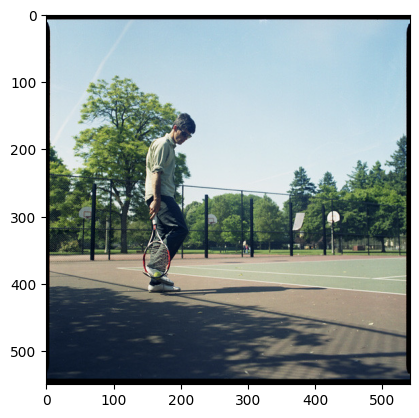

In [13]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [14]:
feat = feature_extractor(images=[sample_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


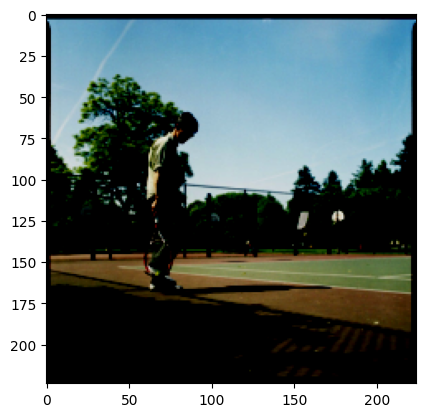

In [15]:
plt.imshow(np.moveaxis(feat.pixel_values[0], 0, -1))
plt.show()

### inspecting `model` object

In [16]:
model.config

VisionEncoderDecoderConfig {
  "_commit_hash": "0e334c70dc5258966aa5775757804d4b62f70125",
  "_name_or_path": "nlpconnect/vit-gpt2-image-captioning",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "bos_token_id": 50256,
  "decoder": {
    "_name_or_path": "",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": 50256,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
   

In [17]:
model.config.encoder.output_attentions = True

In [18]:
pixel_values = feature_extractor(images=[sample_image], return_tensors='pt').pixel_values
pixel_values = pixel_values.to(device)

In [19]:
#requires more inputs
def forward_pass(img):
    # text preprocessing step
    def tokenization_fn(captions, max_target_length):
        """Run tokenization on captions."""
        labels = tokenizer(captions, 
                          padding="max_length", 
                          max_length=max_target_length,return_tensors="pt").input_ids

        return labels

    pixel_values = feature_extractor(images=[img], return_tensors='pt').pixel_values
    pixel_values = pixel_values.to(device)
    ## Can we use without this input???
    text = "hello world"
    labels = tokenization_fn(text, 128)
    labels = labels.to(device)
    outputs = model(pixel_values=pixel_values, labels=labels)
    return outputs

In [20]:
outputs = forward_pass(sample_image)

In [21]:
type(outputs.encoder_attentions)

tuple

In [22]:
type(outputs.decoder_attentions)

NoneType

In [23]:
len(outputs.encoder_attentions)

12

In [24]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 197, 197])

In [25]:
att_map = outputs.encoder_attentions

In [26]:
# renorm_weights = True
# att_map = torch.stack(att_map)
# att_map = att_map.squeeze(1)

# # Average the attention weights across all heads.
# att_map = torch.mean(att_map, dim=1)
# mean_att_map = att_map

# grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))

# if renorm_weights:
#     residual_att = torch.eye(mean_att_map.size(1))
#     residual_att = residual_att.to(device)
#     aug_mean_map = mean_att_map + residual_att
#     aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
#     mean_att_map = aug_mean_map

In [27]:
#mean_att_map.shape

In [28]:
#!pip install opencv-python

In [29]:
import cv2

In [30]:
def get_att_map(att_mat):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att.to(device)
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions = joint_attentions.to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Last layer attention map
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    last_layer = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    last_layer = cv2.resize(last_layer / last_layer.max(), (112,112))[..., np.newaxis]

    #all attention layers for visualization
    all_att_layers = []
    for v in aug_att_mat:
        att_lyr = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
        att_lyr = cv2.resize(att_lyr / att_lyr.max(), (112,112))#[..., np.newaxis]
        all_att_layers.append(att_lyr)
    return last_layer, all_att_layers

def add_annotations(img: Image, annotations: list):
    img_draw = ImageDraw.Draw(img)  
    for ann in annotations:
        #seg = np.array(ann['segmentation'][0], dtype='int')
        if isinstance(ann['segmentation'], list):
            seg = ann['segmentation'][0]
            img_draw.polygon(ann['segmentation'][0], fill ="#eeeeff", outline ="red")
    return img

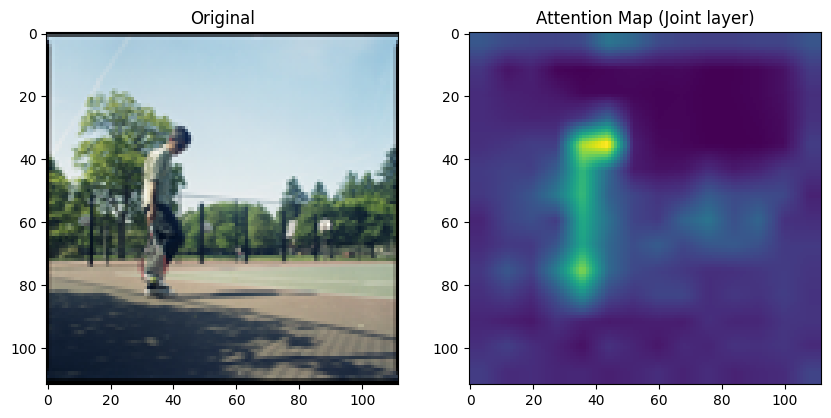

In [31]:
last_layer, all_att_layers = get_att_map(outputs.encoder_attentions)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title('Attention Map (Joint layer)')
_ = ax1.imshow(sample_image.resize((112,112)))
_ = ax2.imshow(last_layer)

### Load a few samples from coco dataset

In [32]:
import json
import copy

In [33]:
# filtered_ids = np.load('../sample_coco_ids_5_4.npy')
# filtered_ids

with open("../sample_coco_ids_person_plus_object_1.json") as f:
    filtered_objects = json.load(f)
filtered_objects

{'27': [225919,
  155997,
  151988,
  153692,
  7125,
  210060,
  133608,
  18783,
  162256,
  69969,
  309071,
  203085,
  298547,
  415672,
  123360,
  323528,
  291179,
  308358,
  298784,
  154830,
  13296,
  204360,
  353577,
  84540,
  210522,
  152543,
  581394,
  440284,
  520427,
  256505,
  4069,
  223874,
  386279,
  450206,
  192128,
  534784,
  32124,
  320246,
  187286,
  525058,
  314986,
  163412,
  83935,
  573214,
  538242,
  559665,
  408449,
  495993,
  4355,
  359451,
  341299,
  19523,
  419790,
  402514,
  560879,
  221547,
  184703,
  333314,
  560890,
  415828,
  530207,
  117037,
  363181,
  7256,
  531069,
  190829,
  255248,
  282658,
  19456,
  5802,
  115370,
  195955,
  156846,
  58364,
  209782,
  150342,
  262672,
  357586,
  48674,
  373988,
  69000,
  380828,
  334321,
  178948,
  388829,
  513073,
  127259,
  432317,
  309528,
  375450,
  472143,
  204507,
  173997,
  34866,
  331289,
  61897,
  208408,
  73527,
  102056,
  318200,
  356394,
  147195

In [34]:
COCO_PATH = "../../../datasets/coco"
with open(os.path.join(COCO_PATH, "annotations/instances_train2017.json"), 'r') as f:
    coco_data = json.load(f)
    
with open(os.path.join(COCO_PATH, "annotations/captions_train2017.json"), 'r') as f:
    coco_captions = json.load(f)       

In [35]:
coco_captions_idx = {ann['image_id']:idx for idx, ann in enumerate(coco_captions['annotations'])}

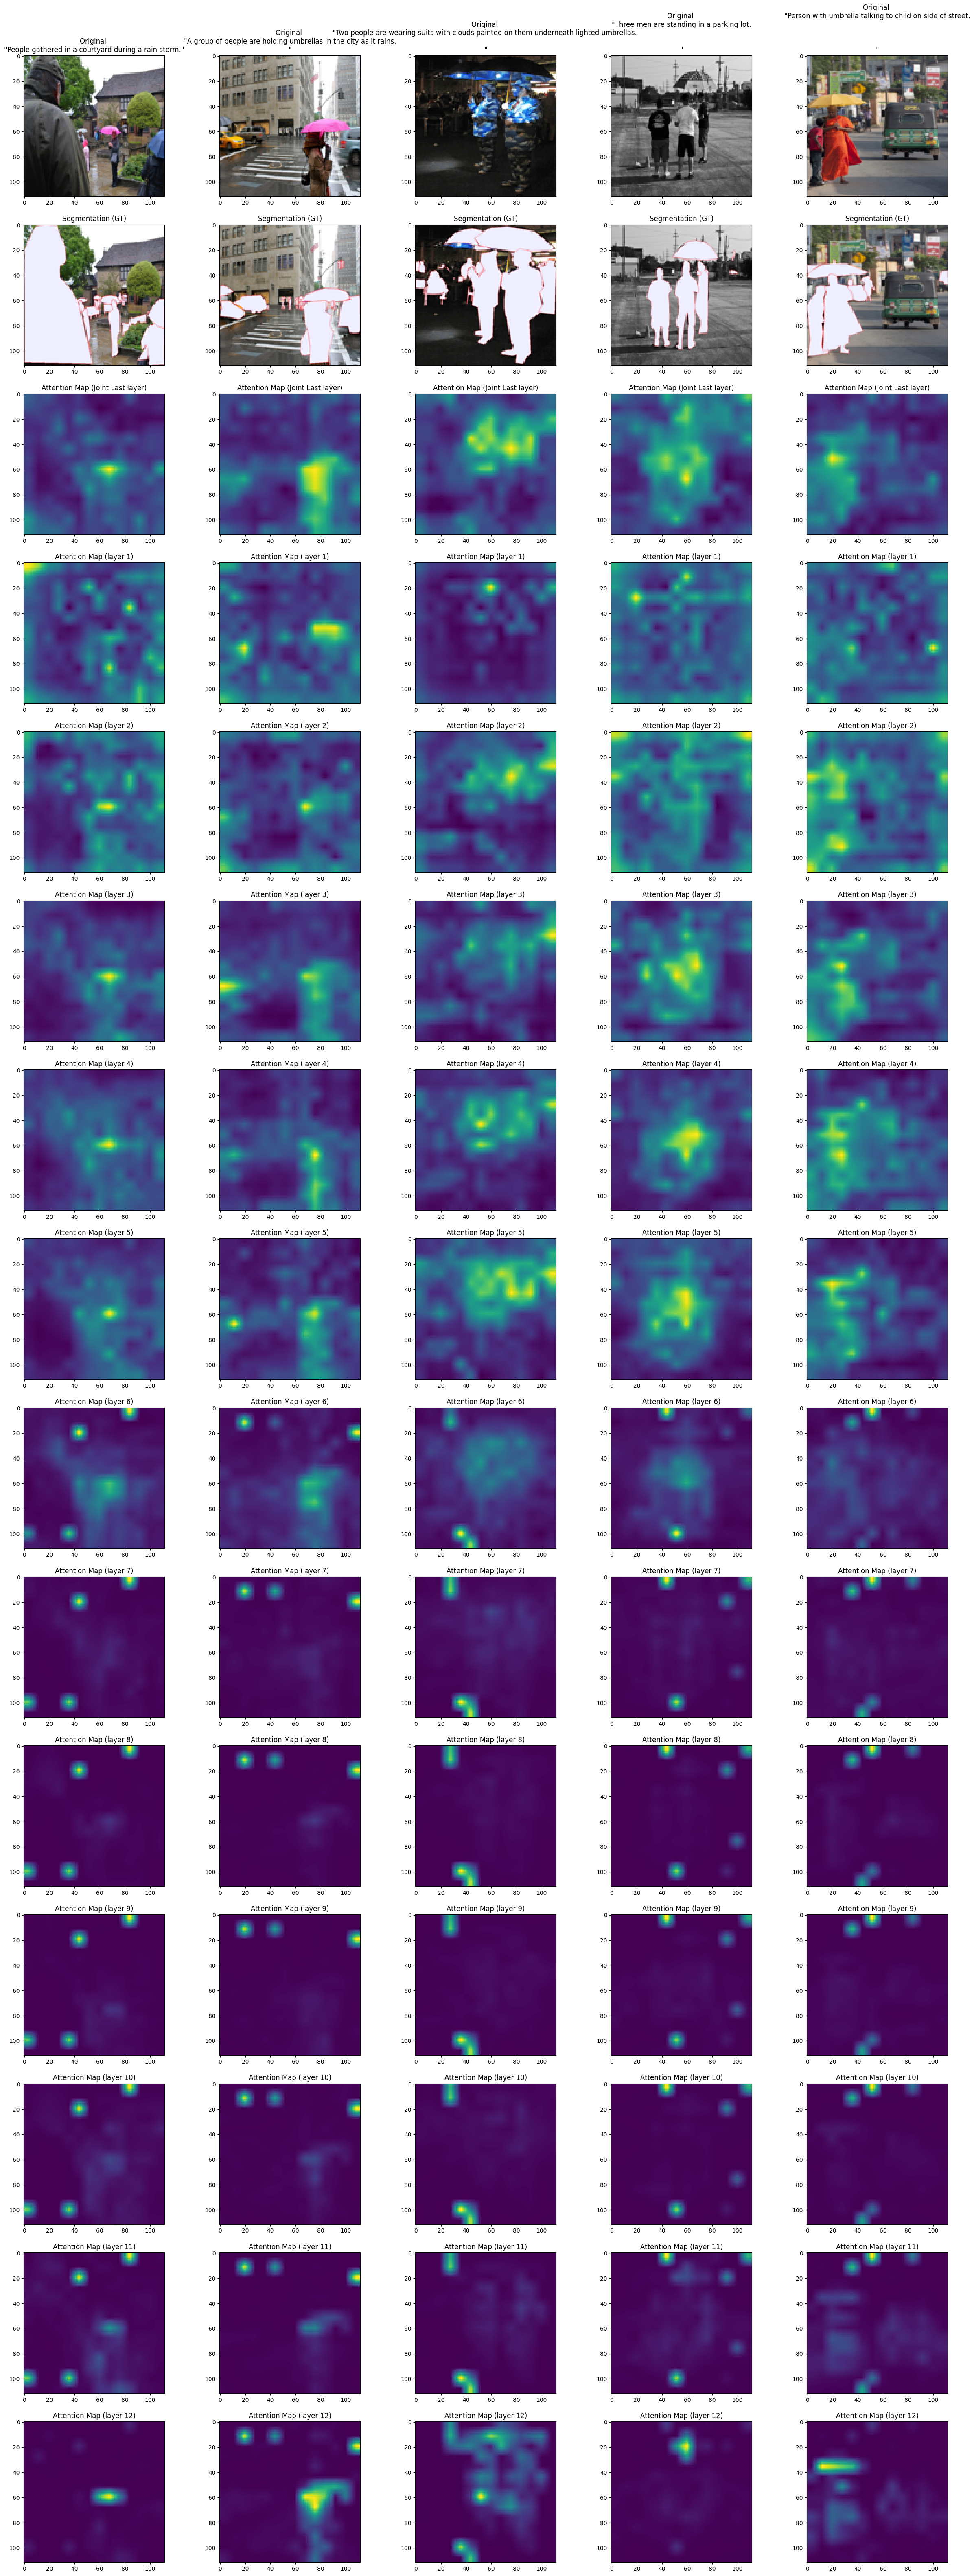

In [36]:
fig, axs = plt.subplots(nrows=15, ncols=5, figsize=(30, 80))

# 27 ['backpack']
# 28 ['umbrella']
# 31 ['handbag']
# 32 ['tie']
# 33 ['suitcase']
# 44 ['bottle']
# 46 ['wine glass']
# 73 ['laptop']
# 77 ['cell phone']

filtered_ids = filtered_objects['28']

for idx, sample_id_ in enumerate(filtered_ids[192:]):
    img_data = None
    for img in coco_data['images']:
        if img['id'] == sample_id_:
            img_data = img
            break
    ann_data = [] 
    for ann in coco_data['annotations']:
        if ann['image_id'] == sample_id_:
            ann_data.append(ann)

    img = Image.open(os.path.join(COCO_PATH, 'train2017', img_data['file_name'])).convert('RGB')    
    outputs = forward_pass(img)
    last_layer, all_att_layers = get_att_map(outputs.encoder_attentions)
    
    caption = coco_captions['annotations'][coco_captions_idx[sample_id_]]["caption"]
    caption += "\n" * idx
    
    axs[0, idx].set_title(f'Original \n"{caption}"')
    axs[0, idx].imshow(img.resize((112,112)))
    
    ann_img = add_annotations(copy.deepcopy(img), ann_data)
    axs[1, idx].set_title('Segmentation (GT)')
    axs[1, idx].imshow(ann_img.resize((112,112)))
        
    axs[2, idx].set_title('Attention Map (Joint Last layer)')
    axs[2, idx].imshow(last_layer)

    for layer_i, att_layer in enumerate(all_att_layers):
        axs[layer_i+3, idx].set_title(f'Attention Map (layer {layer_i+1})')
        axs[layer_i+3, idx].imshow(att_layer)

    if idx==4:
        break
        
plt.show()

In [15]:
def extract_bg_token(img: Image.Image, mask:np.array, transform, renorm_weights=True):
    x = transform(img)
    logits, att_map, layer_activations = model(x.unsqueeze(0))
    att_map = torch.stack(att_map)
    att_map = att_map.squeeze(1)

    # Average the attention weights across all heads.
    att_map = torch.mean(att_map, dim=1)
    mean_att_map = att_map
    
    grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
    
    if renorm_weights:
        residual_att = torch.eye(mean_att_map.size(1))
        aug_mean_map = mean_att_map + residual_att
        aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
        mean_att_map = aug_mean_map
        
    mask_img = copy.deepcopy(np.array(img))
    mask_img[~mask] = 0
    mask_img[mask] = 255
        
    selected_token, _ = find_consistent_bg_token(mean_att_map, np.array(img), mask_img)
    
    return selected_token, mean_att_map, layer_activations

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/generation/utils.py:1278: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [16]:
enc_dec_output

tensor([[50256,    64,   582,   318,  2712, 20790,   319,   257, 20790,  2184,
           220, 50256]], device='cuda:0')

In [8]:
def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
              i_image = i_image.convert(mode="RGB")

        images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors='pt').pixel_values
    print(type(pixel_values))
    print(len(pixel_values))
    print(type(pixel_values[0]))
    print(pixel_values[0].shape)
    print(pixel_values)
    #pixel_values = torch.from_numpy(pixel_values)
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds, pixel_values

In [9]:
#!wget http://farm2.staticflickr.com/1184/526736409_b5dff13989_z.jpg

In [10]:
pred, pixel_values = predict_step(['./526736409_b5dff13989_z.jpg'])

<class 'torch.Tensor'>
1
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9843, -0.9765, -0.9765],
          ...,
          [-0.9922, -1.0000, -1.0000,  ..., -0.9608, -0.9608, -0.9608],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9216, -0.9216, -0.9216],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000,

In [ ]:
#predict_step(['doctor.e16ba4e4.jpg']) # ['a woman in a hospital bed with a woman in a hospital bed']

In [18]:
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [29]:
from transformers import pipeline

In [34]:
image_captioner = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", model_kwargs=enc_args)

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [35]:
image_captioner('./526736409_b5dff13989_z.jpg')

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/generation/utils.py:1278: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[{'generated_text': 'a man is playing tennis on a tennis court '}]

### Questions
1. 